<h5>Herd Behavior Index.

HBI is a quantitative metric to measure the extent at which individual asset returns deviate 
from their respective market average; when an asset moves closely in line with the market's returns, 
it is said to behave "in herd," indicating a strong correlation with market movements. 
Significant deviations from this behavior implies that the stock is moving against the "herd", 
which could be due to unique factors specific to the asset or new market dynamics.

In [2]:
#-- Modules & Packages

import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt

import python_ta as ta

from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

In [3]:
#-- Input Assets and Market index of choice according to yahooFinance naming system.

#-- For crypto we must compare with the only benchmark index BTC-USD price
# asset = ['LTC-USD']
# benchmark = ['BTC-USD']

#-- Whereas for a stock like GOOGLE the benchmark is its market NASDAQ ^IXIC 
# asset = ['GOOG'] 
# benchmark = ['^IXIC']

#-- Cryptocurrency example using BTC-USD as benchmark
asset = ["AVAX-USD"]
benchmark = ['BTC-USD']

In [4]:
#-- Collecting 3 years 
start_date = date.today() + relativedelta(months = - 60)
end_date = date.today()

#-- 1h ohlcv data collection
df_asset = yf.download(asset, start_date, end_date, interval = '1D')
df_benchmark = yf.download(benchmark, start_date, end_date, interval = '1D')

#-- Daily returns 
asset_ret = df_asset['Close'].pct_change().dropna()
benchmark_ret = df_benchmark['Close'].pct_change().dropna()

#-- Rolling window
window_sz =  30

#-- Rolling Herding Behavior Index
rolling_HBI = (np.abs(asset_ret - benchmark_ret).rolling(window_sz).mean() / 
               np.abs(asset_ret).rolling(window_sz).mean())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


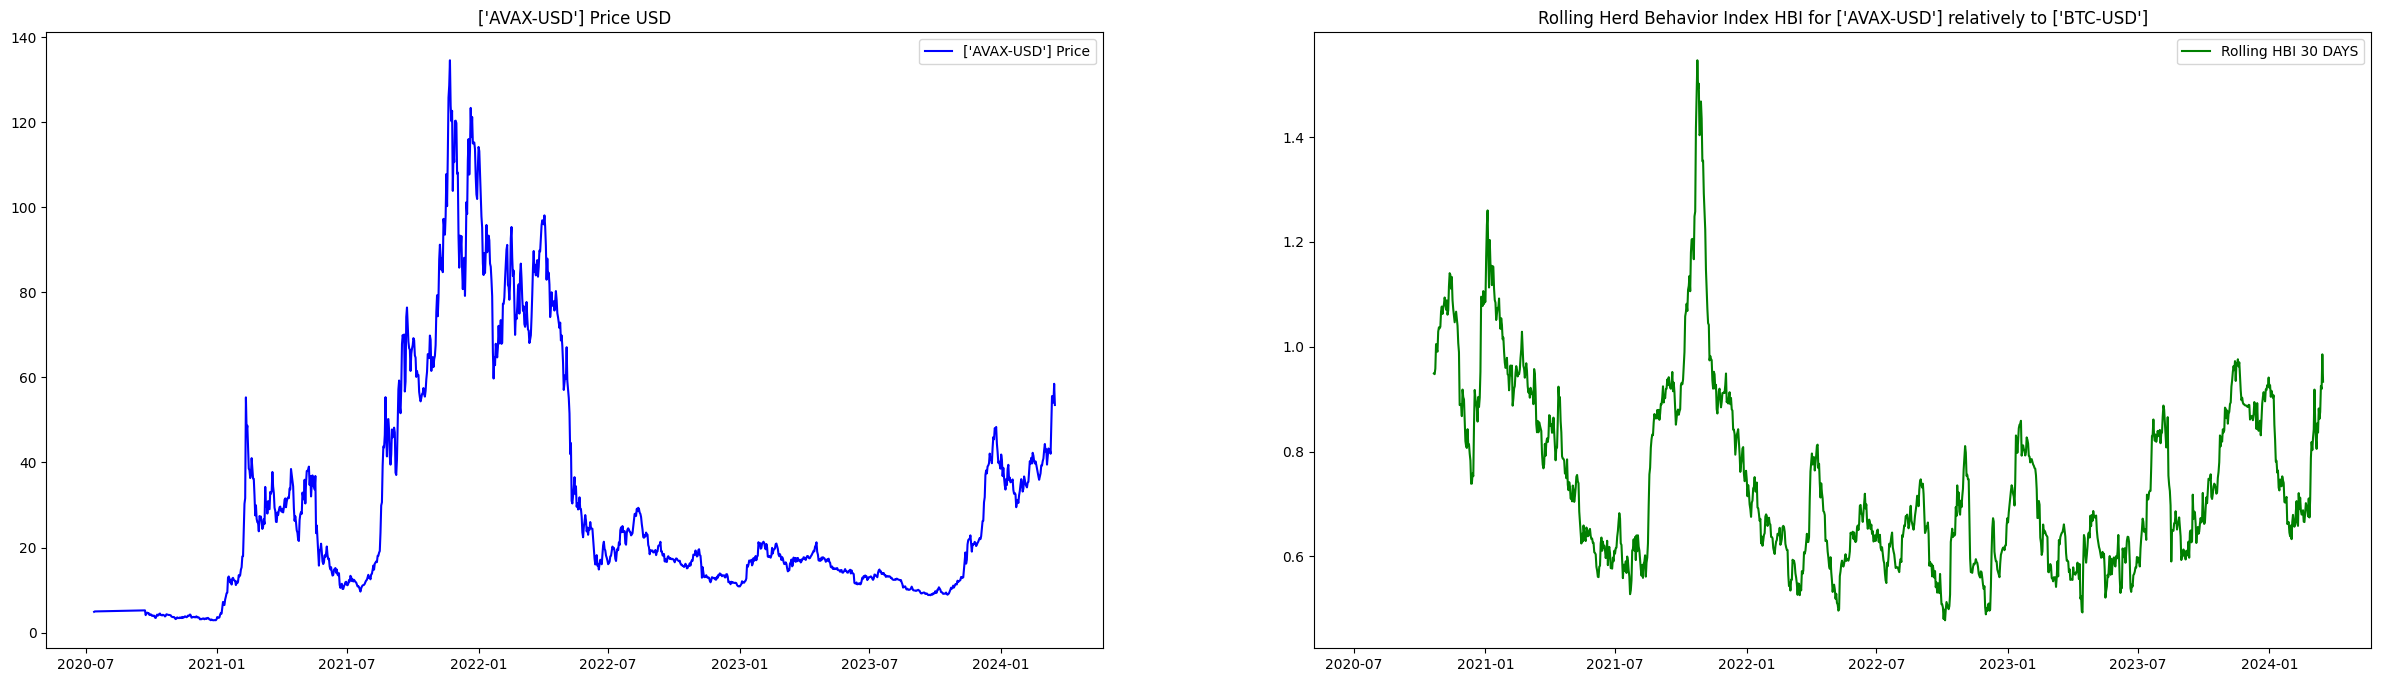

In [5]:
#-- Plotting 

fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(30,8), sharex= True)


#-- Plot of selected asset
ax1.plot(df_asset['Close'], label = f'{asset} Price', color = 'blue')
ax1.set_title(f'{asset} Price USD')
ax1.legend()

#-- Plot of index, benchmark
ax2.plot(rolling_HBI, label = f'Rolling HBI 30 DAYS', color = 'green')
ax2.set_title(f'Rolling Herd Behavior Index HBI for {asset} relatively to {benchmark}')
ax2.legend()

When comparing GOOGLE price with its Rolling Herd Behavior Index HBI, the HBI measures
how strong is the deviation between GOOG returns and the NASDAQ market average returns 
through a rolling 30 day window, lower HBI marks are indicative of returns matching the 
markets returns while higher HBI suggest herding behavior, higher HBI indicate less 
conformity with the market dynamic and trend.

<h5>Rolling Quantile Regression

The RQR plot presents coefficient fluctuation which provide insights into an asset's sensitivity to its Market or Benchmark movements at various quantiles.

In [6]:
#-- Modules & Packages 
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt

import python_ta as ta

from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as smf 
import warnings

#-- Remove warnings
warnings.filterwarnings('ignore')

[*********************100%***********************]  2 of 2 completed


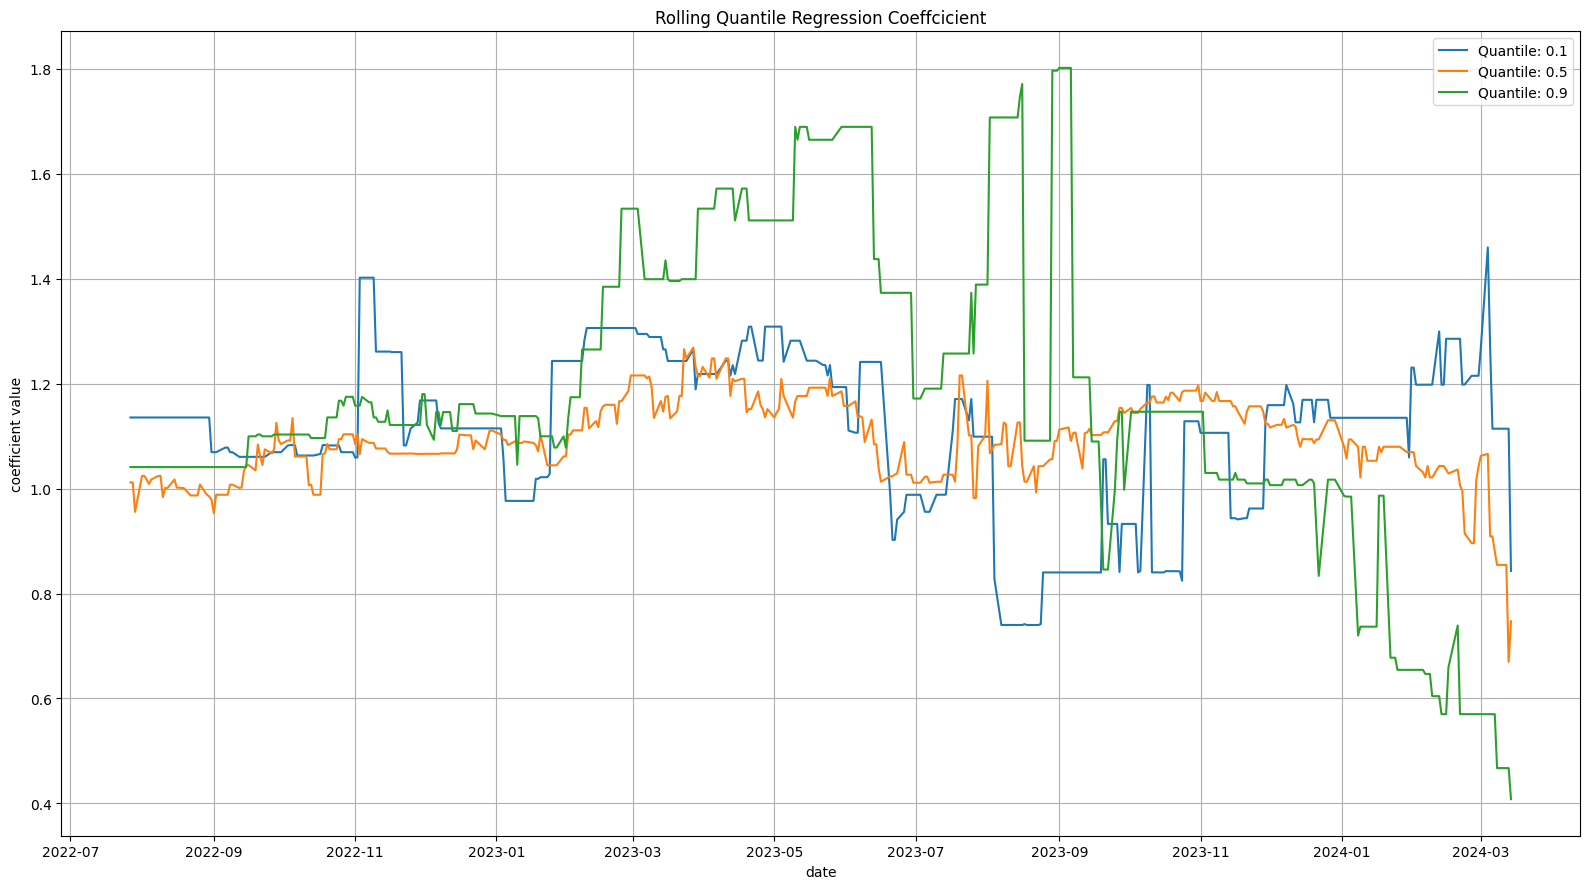

In [7]:
#-- Select asset ticker and market ticker in 

# tickers = ['LTC-USD', 'BTC-USD']

tickers = ['GOOG', '^IXIC']

#-- Collecting only Close price Data
start_date_RQR = date.today() + relativedelta(months = - 24)

df =  yf.download(tickers, start_date_RQR, end_date)['Close']

#-- Daily returns
returns = df.pct_change().dropna()

#-- Dataframe for regression 
reg_df = returns.copy()
reg_df.columns = ["Asset", "Market_idx"]

#-- Defining Rolling Window & Quantiles 

quantiles = [0.1, 0.5, 0.9]
window_sz_q = 90 #-- 3 months of market trading days

#-- Rolling Regression results 
rolling_params = {quantile: {"Intercept": [], "Market_idx": []} for quantile in quantiles}

for start in range(0, len(reg_df) - window_sz_q):
    window_data = reg_df.iloc[start : start + window_sz_q]
    for quantile in quantiles:
        mod = smf.quantreg("Asset ~ Market_idx", window_data)
        res = mod.fit(q = quantile)
        rolling_params[quantile]["Intercept"].append(res.params['Intercept'])
        rolling_params[quantile]["Market_idx"].append(res.params["Market_idx"])

rolling_index = reg_df.index[window_sz_q - 1 : -1]
rolling_dfs = {quantile: pd.DataFrame(data, index = rolling_index) for quantile, data in rolling_params.items()}

#-- Plot

plt.figure(figsize=(16,9))
for quantile in quantiles:
    plt.plot(rolling_dfs[quantile]['Market_idx'], label = f'Quantile: {quantile}')
plt.title("Rolling Quantile Regression Coeffcicient")
plt.xlabel("date")
plt.ylabel("coefficient value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h5>How to read the plot of Rolling Quantile Regression?<br>

<h9>_Looking at the lower quantile 0.1 if it progessively turns negative this <br>
suggests that the asset is progressively sensitive to market downturns.<br>
_A stable coefficient at median 0.5, with no troughs nor spikes, is indicative of <br>
a consistent relationship between the asset and the benchmark or market.<br>

<h5>CSAD: Cross Sectional Absolute Divergence.<br>

<h9>The CSAD calculates the absolute average deviation of each asset's relatively<br>
to the market average return. This approach offers a perspective on herding behavior <br>
by looking at the dispersion of returns across a portfolio of assets.

[                       0%                       ]

[*********************100%***********************]  12 of 12 completed


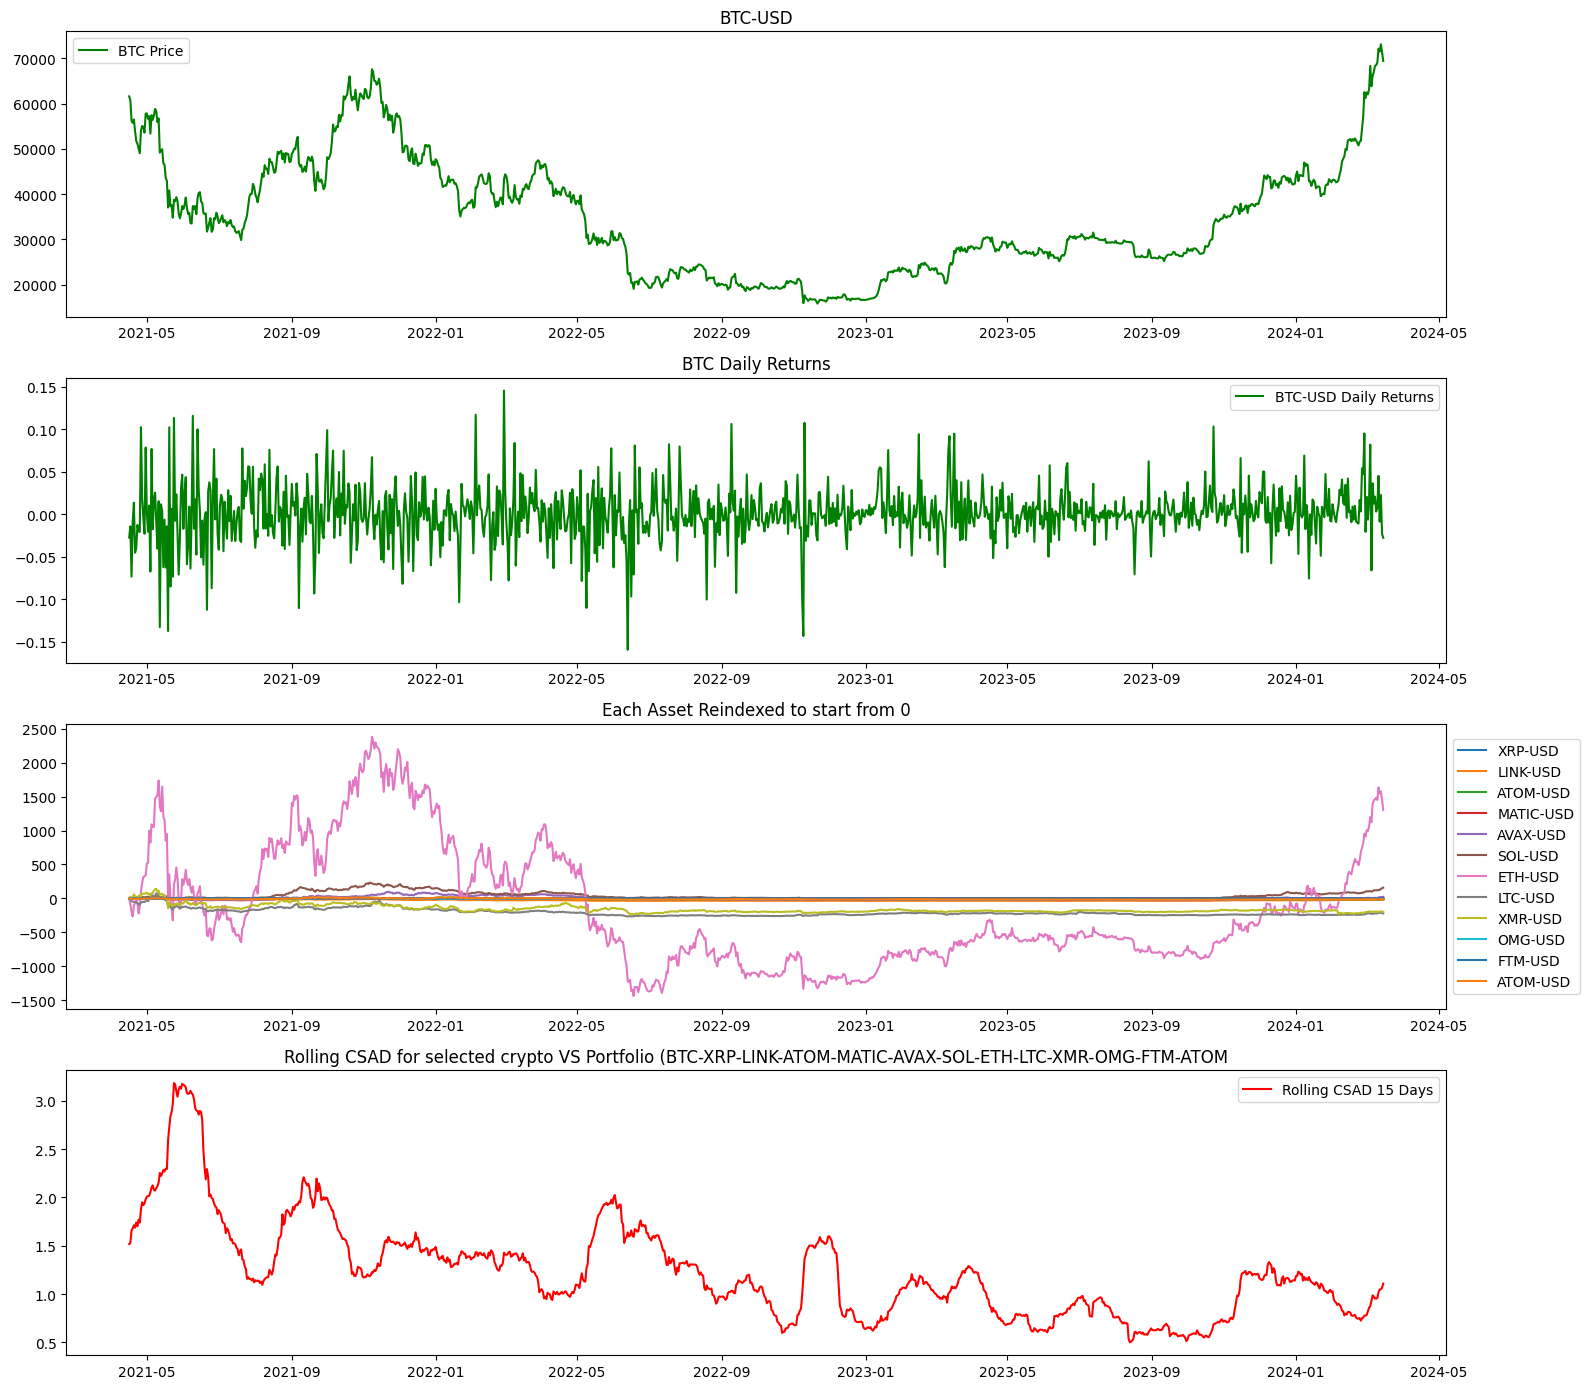

In [15]:
#-- Input tickers to make up portfolio, make sure to follow
#-- naming rules defined by yahooFinance 
tickers_portfolio = ["XRP-USD","LINK-USD", 'ATOM-USD','MATIC-USD','AVAX-USD','SOL-USD',"ETH-USD","LTC-USD","XMR-USD","OMG-USD","FTM-USD","ATOM-USD","BTC-USD"]
#-- Data collecting
start_date_CSAD = date.today() + relativedelta(months = - 36)
data_prtfl =  yf.download(tickers_portfolio, start_date_CSAD, end_date)['Close']

#-- Daily returns 
returns_prtfl = data_prtfl.pct_change().dropna()

#-- Rolling window size 
rolling_window_CSAD = 30

def CSAD_roll(asset_returns, portfolio_returns, window):
    CSAD_values = []
    for i in range(len(asset_returns) - window + 1):
        window_data = asset_returns.iloc[i : i + window]
        window_market = portfolio_returns[i : i + window].mean()
        N = len(window_data.columns)
        CSAD = (N / (N - 1)) * np.sum(np.abs(window_data.sub(window_market, axis = 0)).mean(axis=1)) 
        CSAD_values.append(CSAD)
    return pd.Series(CSAD_values, index = asset_returns.index[window - 1 :]) 

#-- Rolling CSAD for 
rolling_CSAD_values = CSAD_roll(returns_prtfl[: -1], returns_prtfl["AVAX-USD"], rolling_window_CSAD)

aligned_data = data_prtfl.loc[rolling_CSAD_values.index]

aligned_d_zero = aligned_data.sub(aligned_data.iloc[0])

#-- Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(16,14))

ax1.plot(aligned_data["BTC-USD"], label = 'BTC Price', color = 'green')
ax1.set_title("BTC-USD")
ax1.legend()

#-- Plotting benchmark initially selected
ax2.plot(returns_prtfl.loc[rolling_CSAD_values.index, "BTC-USD"], label = "BTC-USD Daily Returns", color = "green")
ax2.set_title("BTC Daily Returns")
ax2.legend()

#-- Plot reindexed stocks 
for asset in tickers_portfolio[:-1]:
    ax3.plot(aligned_d_zero[asset], label = asset)
ax3.set_title("Each Asset Reindexed to start from 0")
ax3.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

#-- Rolling Cross Sectional Absolute Deviation
ax4.plot(rolling_CSAD_values, label = "Rolling CSAD 30 Days", color = "red")
ax4.set_title("Rolling CSAD for selected crypto VS Portfolio (BTC-XRP-LINK-ATOM-MATIC-AVAX-SOL-ETH-LTC-XMR-OMG-FTM-ATOM")
ax4.legend()

plt.tight_layout()
plt.show()

<h5>How to read the plot of CSAD for selected Asset vs Portfolio?<br>

<h9>-Low CSAD values are indicative that individual stocks are moving more in tandem with the market average.<br> 
This could suggest herding behavior among the investors, where they are collectively bullish or bearish, <br>
making stock returns converge.<br>
-High CSAD values imply greater dispersion in the stock returns compared to the market average, <br>
which might reveal less herding behavior among investors and more personal/independent decision-making by investors.<br>